In [1]:
import pandas as pd
import os, gc
import numpy as np
from sklearn.model_selection import KFold

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [2]:
if torch.cuda.is_available():
    print("CUDA (GPU support) is available in PyTorch!")
    device = torch.device("cuda")
else:
    print("CUDA (GPU support) is not available in PyTorch, using CPU instead.")
    device = torch.device("cpu")


CUDA (GPU support) is available in PyTorch!


In [3]:
# Fix fastai bug to enable fp16 training with dictionaries

import torch
from fastai.vision.all import *
def flatten(o):
    "Concatenate all collections and items as a generator"
    for item in o:
        if isinstance(o, dict): yield o[item]; continue
        elif isinstance(item, str): yield item; continue
        try: yield from flatten(item)
        except TypeError: yield item

from torch.cuda.amp import GradScaler, autocast
@delegates(GradScaler)
class MixedPrecision(Callback):
    "Mixed precision training using Pytorch's `autocast` and `GradScaler`"
    order = 10
    def __init__(self, **kwargs): self.kwargs = kwargs
    def before_fit(self): 
        self.autocast,self.learn.scaler,self.scales = autocast(),GradScaler(**self.kwargs),L()
    def before_batch(self): self.autocast.__enter__()
    def after_pred(self):
        if next(flatten(self.pred)).dtype==torch.float16: self.learn.pred = to_float(self.pred)
    def after_loss(self): self.autocast.__exit__(None, None, None)
    def before_backward(self): self.learn.loss_grad = self.scaler.scale(self.loss_grad)
    def before_step(self):
        "Use `self` as a fake optimizer. `self.skipped` will be set to True `after_step` if gradients overflow. "
        self.skipped=True
        self.scaler.step(self)
        if self.skipped: raise CancelStepException()
        self.scales.append(self.scaler.get_scale())
    def after_step(self): self.learn.scaler.update()

    @property 
    def param_groups(self): 
        "Pretend to be an optimizer for `GradScaler`"
        return self.opt.param_groups
    def step(self, *args, **kwargs): 
        "Fake optimizer step to detect whether this batch was skipped from `GradScaler`"
        self.skipped=False
    def after_fit(self): self.autocast,self.learn.scaler,self.scales = None,None,None
        
import fastai
fastai.callback.fp16.MixedPrecision = MixedPrecision


In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [5]:
fname = 'example0'
PATH = ''
OUT = './out/'
bs = 256
num_workers = 2
SEED = 2023
nfolds = 4
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
from rna_dataset import RNA_Dataset, LenMatchBatchSampler, dict_to, to_device, DeviceDataLoader

In [7]:
'''os.makedirs(OUT, exist_ok=True)
df = pd.read_parquet(os.path.join(PATH,'train_data.parquet'))

# Create an instance of RNA_Dataset
rna_dataset = RNA_Dataset(df)

# Get the shortest sequence length
shortest_length = rna_dataset.get_min_sequence_length()
longest_length = rna_dataset.get_max_sequence_length()

print("Shortest sequence length:", shortest_length)
print("Longest sequence length:", longest_length)'''

'os.makedirs(OUT, exist_ok=True)\ndf = pd.read_parquet(os.path.join(PATH,\'train_data.parquet\'))\n\n# Create an instance of RNA_Dataset\nrna_dataset = RNA_Dataset(df)\n\n# Get the shortest sequence length\nshortest_length = rna_dataset.get_min_sequence_length()\nlongest_length = rna_dataset.get_max_sequence_length()\n\nprint("Shortest sequence length:", shortest_length)\nprint("Longest sequence length:", longest_length)'

In [8]:
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim=16, M=10000):
        super().__init__()
        self.dim = dim
        self.M = M

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(self.M) / half_dim
        emb = torch.exp(torch.arange(half_dim, device=device) * (-emb))
        emb = x[...,None] * emb[None,...]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb

class RNA_Model(nn.Module):
    def __init__(self, dim=192, depth=12, head_size=32, **kwargs):
        super().__init__()
        self.emb = nn.Embedding(4,dim)
        self.pos_enc = SinusoidalPosEmb(dim)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=dim, nhead=dim//head_size, dim_feedforward=4*dim,
                dropout=0.1, activation=nn.GELU(), batch_first=True, norm_first=True), depth)
        self.proj_out = nn.Linear(dim,2)
    
    def forward(self, x0):
        mask = x0['mask']
        Lmax = mask.sum(-1).max()
        mask = mask[:,:Lmax]
        x = x0['seq'][:,:Lmax]
        
        pos = torch.arange(Lmax, device=x.device).unsqueeze(0)
        pos = self.pos_enc(pos)
        x = self.emb(x)
        x = x + pos
        
        x = self.transformer(x, src_key_padding_mask=~mask)
        x = self.proj_out(x)
        
        return x

In [9]:
def loss(pred,target):
    p = pred[target['mask'][:,:pred.shape[1]]]
    y = target['react'][target['mask']].clip(0,1)
    loss = F.l1_loss(p, y, reduction='none')
    loss = loss[~torch.isnan(loss)].mean()
    
    return loss

class MAE(Metric):
    def __init__(self): 
        self.reset()
        
    def reset(self): 
        self.x,self.y = [],[]
        
    def accumulate(self, learn):
        x = learn.pred[learn.y['mask'][:,:learn.pred.shape[1]]]
        y = learn.y['react'][learn.y['mask']].clip(0,1)
        self.x.append(x)
        self.y.append(y)

    @property
    def value(self):
        x,y = torch.cat(self.x,0),torch.cat(self.y,0)
        loss = F.l1_loss(x, y, reduction='none')
        loss = loss[~torch.isnan(loss)].mean()
        return loss

In [10]:
seed_everything(SEED)
'''
for fold in [0]: # running multiple folds at kaggle may cause OOM
    ds_train = RNA_Dataset(df, mode='train', fold=fold, nfolds=nfolds)
    ds_train_len = RNA_Dataset(df, mode='train', fold=fold, 
                nfolds=nfolds, mask_only=True)
    sampler_train = torch.utils.data.RandomSampler(ds_train_len)
    len_sampler_train = LenMatchBatchSampler(sampler_train, batch_size=bs,
                drop_last=True)
    dl_train = DeviceDataLoader(torch.utils.data.DataLoader(ds_train, 
                batch_sampler=len_sampler_train, num_workers=num_workers,
                persistent_workers=True), device)

    ds_val = RNA_Dataset(df, mode='eval', fold=fold, nfolds=nfolds)
    ds_val_len = RNA_Dataset(df, mode='eval', fold=fold, nfolds=nfolds, 
               mask_only=True)
    sampler_val = torch.utils.data.SequentialSampler(ds_val_len)
    len_sampler_val = LenMatchBatchSampler(sampler_val, batch_size=bs, 
               drop_last=False)
    dl_val= DeviceDataLoader(torch.utils.data.DataLoader(ds_val, 
               batch_sampler=len_sampler_val, num_workers=num_workers), device)
    gc.collect()

    data = DataLoaders(dl_train,dl_val)
    model = RNA_Model()   
    model = model.to(device)
    learn = Learner(data, model, loss_func=loss,cbs=[GradientClip(3.0)],
                metrics=[MAE()]).to_fp16() 
    #fp16 doesn't help at P100 but gives x1.6-1.8 speedup at modern hardware

    learn.fit_one_cycle(32, lr_max=5e-4, wd=0.05, pct_start=0.02)
    torch.save(learn.model.state_dict(),os.path.join(OUT,f'{fname}_{fold}.pth'))
    gc.collect()'''

"\nfor fold in [0]: # running multiple folds at kaggle may cause OOM\n    ds_train = RNA_Dataset(df, mode='train', fold=fold, nfolds=nfolds)\n    ds_train_len = RNA_Dataset(df, mode='train', fold=fold, \n                nfolds=nfolds, mask_only=True)\n    sampler_train = torch.utils.data.RandomSampler(ds_train_len)\n    len_sampler_train = LenMatchBatchSampler(sampler_train, batch_size=bs,\n                drop_last=True)\n    dl_train = DeviceDataLoader(torch.utils.data.DataLoader(ds_train, \n                batch_sampler=len_sampler_train, num_workers=num_workers,\n                persistent_workers=True), device)\n\n    ds_val = RNA_Dataset(df, mode='eval', fold=fold, nfolds=nfolds)\n    ds_val_len = RNA_Dataset(df, mode='eval', fold=fold, nfolds=nfolds, \n               mask_only=True)\n    sampler_val = torch.utils.data.SequentialSampler(ds_val_len)\n    len_sampler_val = LenMatchBatchSampler(sampler_val, batch_size=bs, \n               drop_last=False)\n    dl_val= DeviceDataLoad

In [11]:
import pandas as pd

# Load data
df = pd.read_parquet(os.path.join(PATH, 'train_data.parquet'))


In [12]:
'''
# Add a column for sequence length
df['seq_length'] = df['sequence'].apply(len)

# Sort by sequence length
df_sorted = df.sort_values(by='seq_length')

# Determine indices for shortest and longest 10%
num_sequences = len(df_sorted)
shortest_10_pct_index = int(num_sequences * 0.1)
longest_10_pct_index = int(num_sequences * 0.9)

# Create training and validation datasets
train_df = df_sorted.iloc[:shortest_10_pct_index].copy()
val_df = df_sorted.iloc[longest_10_pct_index:].copy()

# Assuming RNA_Dataset is modified to skip K-Fold if 'fold' is None
ds_train = RNA_Dataset(train_df, mode='train', use_kfold=False)
ds_val = RNA_Dataset(val_df, mode='eval', use_kfold=False)

# Create DataLoaders
dl_train = DeviceDataLoader(DataLoader(ds_train, batch_size=bs, shuffle=True, num_workers=num_workers), device)
dl_val = DeviceDataLoader(DataLoader(ds_val, batch_size=bs, shuffle=False, num_workers=num_workers), device)

# Rest of your training setup
data = DataLoaders(dl_train, dl_val)
model = RNA_Model()
model.to(device)
learn = Learner(data, model, loss_func=loss, cbs=[GradientClip(3.0)], metrics=[MAE()]).to_fp16()

# Training
learn.fit_one_cycle(32, lr_max=5e-4, wd=0.05, pct_start=0.02)

# Save model
torch.save(learn.model.state_dict(), os.path.join(OUT, f'{fname}_custom_split.pth'))
'''

"\n# Add a column for sequence length\ndf['seq_length'] = df['sequence'].apply(len)\n\n# Sort by sequence length\ndf_sorted = df.sort_values(by='seq_length')\n\n# Determine indices for shortest and longest 10%\nnum_sequences = len(df_sorted)\nshortest_10_pct_index = int(num_sequences * 0.1)\nlongest_10_pct_index = int(num_sequences * 0.9)\n\n# Create training and validation datasets\ntrain_df = df_sorted.iloc[:shortest_10_pct_index].copy()\nval_df = df_sorted.iloc[longest_10_pct_index:].copy()\n\n# Assuming RNA_Dataset is modified to skip K-Fold if 'fold' is None\nds_train = RNA_Dataset(train_df, mode='train', use_kfold=False)\nds_val = RNA_Dataset(val_df, mode='eval', use_kfold=False)\n\n# Create DataLoaders\ndl_train = DeviceDataLoader(DataLoader(ds_train, batch_size=bs, shuffle=True, num_workers=num_workers), device)\ndl_val = DeviceDataLoader(DataLoader(ds_val, batch_size=bs, shuffle=False, num_workers=num_workers), device)\n\n# Rest of your training setup\ndata = DataLoaders(dl_tr

In [13]:
# Add a column for sequence length
df['seq_length'] = df['sequence'].apply(len)

# Identify the minimum and maximum sequence lengths
min_length = df['seq_length'].min()
max_length = df['seq_length'].max()

# Filter the DataFrame to get all sequences with the minimum length for training
train_df = df[df['seq_length'] == min_length].copy()

# Filter the DataFrame to get all sequences with the maximum length for validation
val_df = df[df['seq_length'] == max_length].copy()

# Create RNA_Dataset instances for training and validation
ds_train = RNA_Dataset(train_df, mode='train', use_kfold=False)
ds_val = RNA_Dataset(val_df, mode='eval', use_kfold=False)

# Create DataLoaders
dl_train = DeviceDataLoader(DataLoader(ds_train, batch_size=bs, shuffle=True, num_workers=num_workers), device)
dl_val = DeviceDataLoader(DataLoader(ds_val, batch_size=bs, shuffle=False, num_workers=num_workers), device)


epoch,train_loss,valid_loss,mae,time
0,0.877140,0.422079,0.422079,00:14
1,0.515600,0.284770,0.284770,00:13
2,0.355612,0.326947,0.326947,00:13
3,0.265802,0.280424,0.280424,00:13
4,0.224250,0.271225,0.271225,00:13
5,0.207798,0.269002,0.269002,00:13
6,0.200516,0.270328,0.270328,00:13
7,0.197110,0.268766,0.268766,00:13
8,0.195284,0.260261,0.260261,00:13
9,0.194368,0.262925,0.262925,00:13


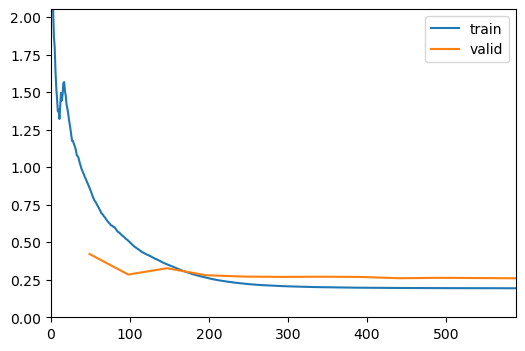

In [14]:

# Rest of your training setup
data = DataLoaders(dl_train, dl_val)
model = RNA_Model()   
model.to(device)
learn = Learner(data, model, loss_func=loss, cbs=[GradientClip(3.0)], metrics=[MAE()]).to_fp16()

# Training
learn.fit_one_cycle(12, lr_max=5e-4, wd=0.05, pct_start=0.02, cbs=ShowGraphCallback())

# Save model
torch.save(learn.model.state_dict(), os.path.join(OUT, 'SinusoidalPosEmb.pth'))


In [15]:
import math

class RotaryPositionalEmbedding(nn.Module):
    def __init__(self, dim, max_seq_len=512):
        super().__init__()
        self.dim = dim
        self.max_seq_len = max_seq_len
        inv_freq = 1.0 / (10000 ** (torch.arange(0, dim, 2).float() / dim))
        t = torch.arange(max_seq_len).type_as(inv_freq)
        freqs = torch.einsum('n,d->nd', t, inv_freq)
        self.register_buffer('sin', freqs.sin())
        self.register_buffer('cos', freqs.cos())

    def forward(self, x):
        seq_len = x.size(1)
        sin, cos = self.sin[:seq_len, :self.dim//2], self.cos[:seq_len, :self.dim//2]
        emb = torch.cat((sin, cos), dim=-1).unsqueeze(0)
        return x + emb

    def get_angles(self, pos, i, d_model):
        angle_rates = 1 / torch.pow(10000, (2 * (i//2)) / d_model)
        return pos * angle_rates

class RNA_Model(nn.Module):
    def __init__(self, dim=192, depth=12, head_size=32, max_seq_len=512, **kwargs): #lets my model learn a length of up to 512
        super().__init__()
        self.emb = nn.Embedding(4, dim)
        self.pos_enc = RotaryPositionalEmbedding(dim, max_seq_len)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=dim, nhead=dim//head_size, dim_feedforward=4*dim,
                dropout=0.1, activation=nn.GELU(), batch_first=True, norm_first=True), depth)
        self.proj_out = nn.Linear(dim, 2)
    
    def forward(self, x0):
        mask = x0['mask']
        Lmax = mask.sum(-1).max()
        mask = mask[:, :Lmax]
        x = x0['seq'][:, :Lmax]
        
        x = self.emb(x)
        x = self.pos_enc(x)
        
        x = self.transformer(x, src_key_padding_mask=~mask)
        x = self.proj_out(x)
        
        return x


epoch,train_loss,valid_loss,mae,time
0,1.241149,0.851908,0.851908,00:13
1,0.698910,0.435904,0.435904,00:13
2,0.431011,0.272500,0.272500,00:13
3,0.310985,0.302321,0.302321,00:13
4,0.252670,0.256023,0.256023,00:13
5,0.218935,0.252815,0.252815,00:13
6,0.205216,0.255632,0.255632,00:13
7,0.199672,0.258114,0.258114,00:13
8,0.197037,0.255152,0.255152,00:13
9,0.195608,0.257557,0.257557,00:13


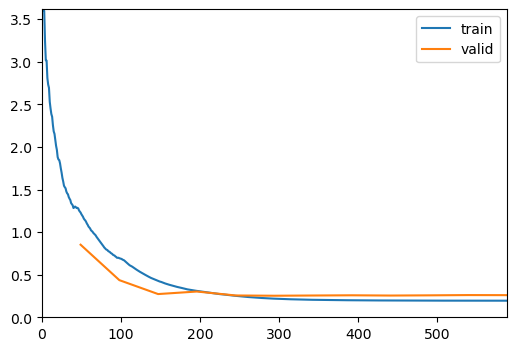

In [16]:

data = DataLoaders(dl_train, dl_val)
model = RNA_Model()   
model.to(device)
learn = Learner(data, model, loss_func=loss, cbs=[GradientClip(3.0)], metrics=[MAE()]).to_fp16()

learn.fit_one_cycle(12, lr_max=5e-4, wd=0.05, pct_start=0.02, cbs=ShowGraphCallback())

torch.save(learn.model.state_dict(), os.path.join(OUT, 'RoPeEmb.pth'))


In [17]:
class ALiBi(nn.Module):
    def __init__(self, heads, max_seq_len):
        super().__init__()
        self.slopes = nn.Parameter(torch.ones(heads, 1, 1) * (max_seq_len ** -0.5))

    def forward(self, attn):
        seq_len = attn.size(-1)
        range_tensor = torch.arange(seq_len).unsqueeze(0).to(attn.device)
        distance_matrix = range_tensor - range_tensor.T
        distance_matrix = distance_matrix.abs().unsqueeze(0).unsqueeze(0)

        bias = self.slopes * distance_matrix
        return attn + bias

class ALiBiTransformerEncoderLayer(nn.TransformerEncoderLayer):
    def __init__(self, nhead, max_seq_len, d_model, dim_feedforward=768, dropout=0.1, activation=nn.GELU(), batch_first=True, norm_first=True):
        super().__init__(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout, activation=activation, batch_first=batch_first, norm_first=norm_first)
        self.alibi = ALiBi(nhead, max_seq_len)
        
    def forward(self, src, src_mask=None, src_key_padding_mask=None, is_causal=False):
        attn_output, attn_scores = self.self_attn(src, src, src, attn_mask=src_mask, key_padding_mask=src_key_padding_mask)

        if attn_scores is not None and len(attn_scores.shape) == 4:
            attn_scores = self.alibi(attn_scores)
            src2 = attn_output + attn_scores
        else:
            src2 = attn_output

        src = src + self.dropout1(src2)
        src = self.norm1(src)
        src2 = self.linear2(self.dropout(self.activation(self.linear1(src))))
        src = src + self.dropout2(src2)
        src = self.norm2(src)
        return src

class RNA_Model(nn.Module):
    def __init__(self, dim=192, depth=12, head_size=32, max_seq_len=512, **kwargs):
        super().__init__()
        self.emb = nn.Embedding(4, dim)
        nhead = dim // head_size
        encoder_layer = ALiBiTransformerEncoderLayer(nhead=nhead, max_seq_len=max_seq_len, d_model=dim, 
                                                      dim_feedforward=4 * dim, dropout=0.1, 
                                                     activation=nn.GELU(), batch_first=True, 
                                                     norm_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, depth)
        self.proj_out = nn.Linear(dim, 2)

    def forward(self, x0):
        mask = x0['mask']
        Lmax = mask.sum(-1).max()
        mask = mask[:, :Lmax]
        x = x0['seq'][:, :Lmax]
        x = self.emb(x)
        x = self.transformer(x, src_key_padding_mask=~mask)
        x = self.proj_out(x)
        return x

epoch,train_loss,valid_loss,mae,time
0,0.283140,0.247926,0.247926,00:15
1,0.243353,0.243735,0.243735,00:14
2,0.231009,0.230720,0.230720,00:15
3,0.225404,0.236507,0.236507,00:14
4,0.222900,0.241802,0.241802,00:15
5,0.221950,0.240386,0.240386,00:15
6,0.221349,0.241956,0.241956,00:14
7,0.220878,0.238074,0.238074,00:15
8,0.220593,0.236242,0.236242,00:14
9,0.220421,0.240065,0.240065,00:14


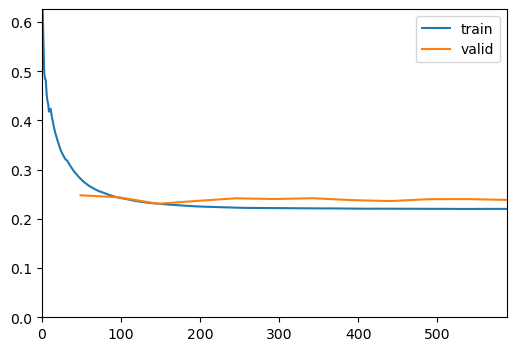

In [18]:

# Rest of your training setup
data = DataLoaders(dl_train, dl_val)
model = RNA_Model()   
model.to(device)
learn = Learner(data, model, loss_func=loss, cbs=[GradientClip(3.0)], metrics=[MAE()]).to_fp16()

# Training
learn.fit_one_cycle(12, lr_max=5e-4, wd=0.05, pct_start=0.02, cbs=ShowGraphCallback())

# Save model
torch.save(learn.model.state_dict(), os.path.join(OUT, 'aLiBi.pth'))


In [19]:
import torch.nn.functional as F
class DynamicPositionalBias(nn.Module):
    def __init__(self, dim=16):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        seq_len = x.size(1)
        device = x.device  
        pos = torch.arange(seq_len, device=device).unsqueeze(-1)
        bias = torch.zeros(seq_len, self.dim, device=device)
        bias[:, 0::2] = torch.sin(pos / (10000 ** (torch.arange(0, self.dim, 2, device=device) / self.dim)))
        bias[:, 1::2] = torch.cos(pos / (10000 ** (torch.arange(1, self.dim, 2, device=device) / self.dim)))

        return bias

class RNA_Model(nn.Module):
    def __init__(self, dim=192, depth=12, head_size=32, **kwargs):
        super().__init__()
        self.emb = nn.Embedding(4, dim)
        self.pos_bias = DynamicPositionalBias(dim) 
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=dim, nhead=dim // head_size, dim_feedforward=4 * dim,
                                       dropout=0.1, activation=nn.GELU(), batch_first=True, norm_first=True), depth)
        self.proj_out = nn.Linear(dim, 2)

    def forward(self, x0):
        mask = x0['mask']
        Lmax = mask.sum(-1).max()
        mask = mask[:, :Lmax]
        x = x0['seq'][:, :Lmax]

        pos_bias = self.pos_bias(x)  
        x = self.emb(x)

        x = self.transformer(x, src_key_padding_mask=~mask)
        x = self.proj_out(x)

        return x


epoch,train_loss,valid_loss,mae,time
0,0.753603,0.498448,0.498448,00:13
1,0.472780,0.321343,0.321343,00:13
2,0.356091,0.372943,0.372943,00:13
3,0.290904,0.253575,0.253575,00:13
4,0.249238,0.231992,0.231992,00:13
5,0.232405,0.240515,0.240515,00:13
6,0.225645,0.238853,0.238853,00:13
7,0.222875,0.234932,0.234932,00:13
8,0.221712,0.238669,0.238669,00:13
9,0.221276,0.237864,0.237864,00:13


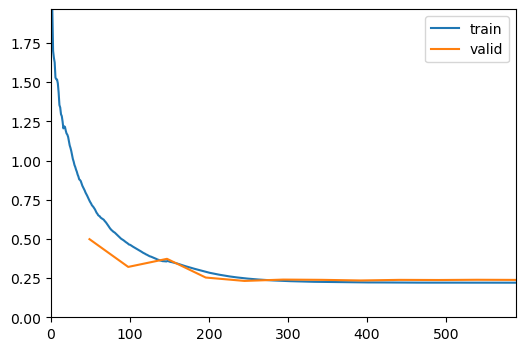

In [20]:
data = DataLoaders(dl_train, dl_val)
model = RNA_Model()   
model.to(device)
learn = Learner(data, model, loss_func=loss, cbs=[GradientClip(3.0)], metrics=[MAE()]).to_fp16()

learn.fit_one_cycle(12, lr_max=5e-4, wd=0.05, pct_start=0.02, cbs=ShowGraphCallback())

torch.save(learn.model.state_dict(), os.path.join(OUT, 'dynamic.pth'))
